### Исследование поведения клиентов фитнес-центра.

Наши задачи: 
- спрогнозировать вероятность оттока каждого клиента;
- разбить пользователей на кластеры и сформировать типичные портреты;
- проанализировать основные признаки, наиболее сильно влияющие на отток.

1. [Чтение данных](#reading)
2. [Предобработка данных](#EDA)
3. [Модель прогнозирования оттока пользователей](#churn_prediction)
4. [Кластеризация пользователей](#user_clusterization)
5. [Рекомендации и выводы](#conclusion)

<a id="reading"></a>
#### Шаг 1. Чтение данных.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
# посмотрим на наши данные
gym = pd.read_csv('gym_churn.csv')
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<a id="EDA"></a>
#### Шаг 2. Предобработка данных.

In [3]:
gym.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [4]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Форматы данных корректны, пропусков нет.

In [5]:
# сгруппируем данные по признаку оттока
gym_grouped = gym.groupby('Churn').agg('mean')
gym_grouped

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Первые предположения: более вероятен отток тех, кто

- дальше живет
- не включен в партнерскую программу
- не пользовался промокодом друга
- имеет краткосрочный договор
- не ходит на групповые занятия
- мало тратит
- пользуется фитнес-центром недавно
- редко ходит в спортзал, особенно последнее время
- моложе

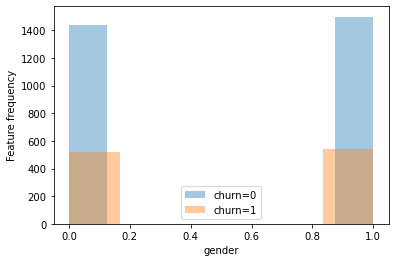

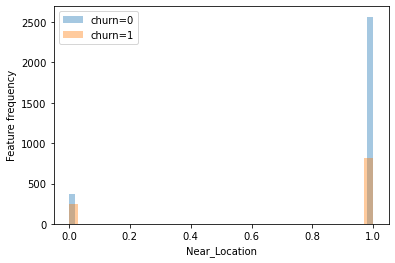

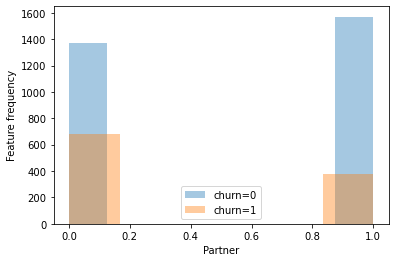

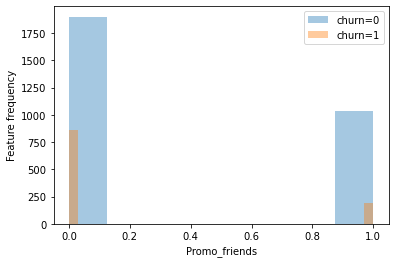

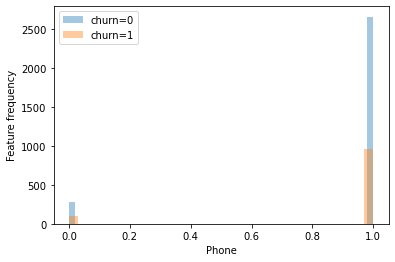

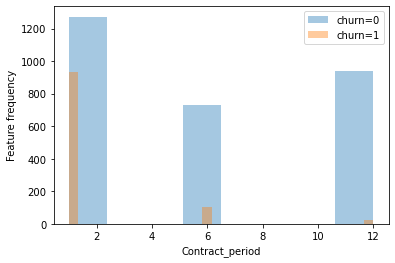

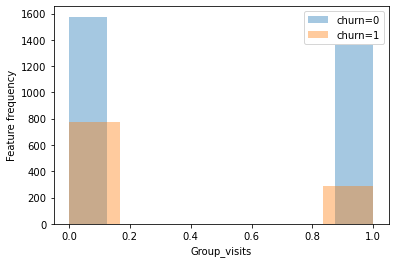

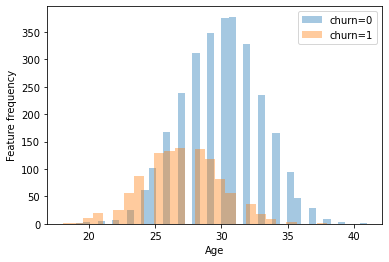

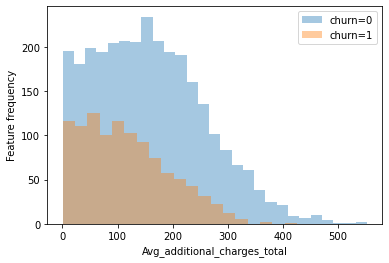

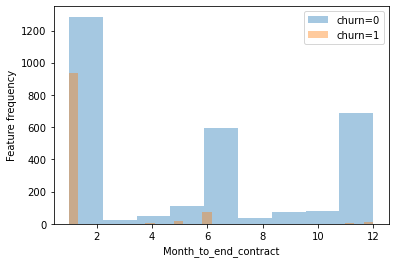

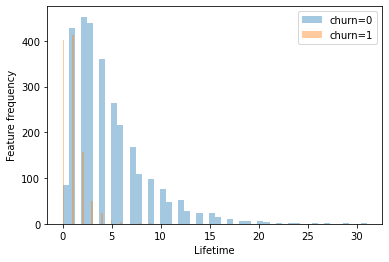

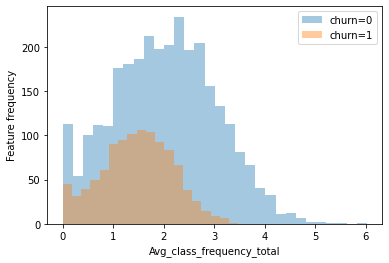

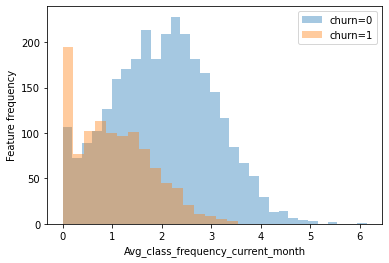

In [6]:
# посмотрим на распределения признаков
for i in gym.columns[:-1]:
    sns.distplot(gym[gym['Churn']==0][i], kde=False, label="churn=0")
    sns.distplot(gym[gym['Churn']==1][i], kde=False, label="churn=1")
    plt.xlabel(i)
    plt.ylabel('Feature frequency')
    plt.legend()
    plt.show()


Графики распределения подтверждают наши догадки: склонные к оттоку клиенты меньше платят, заключают краткосрочные договора и реже пользуются услугами фитнес-центра.

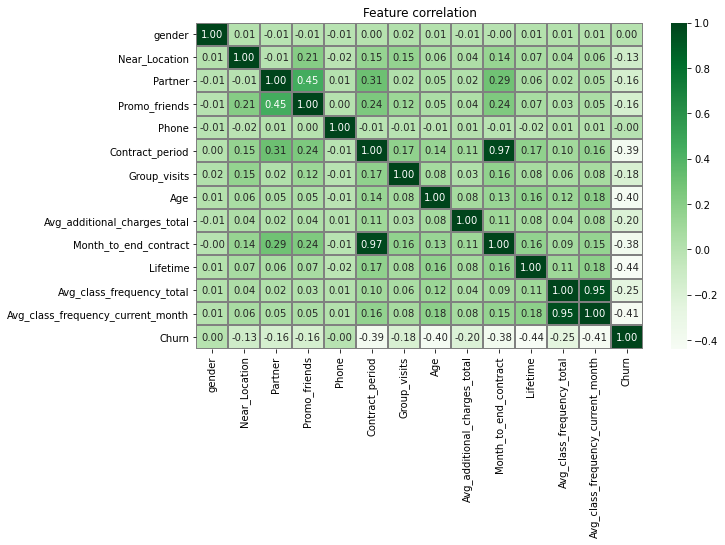

In [7]:
cm = gym.corr() #вычисляем матрицу корреляций
plt.figure(figsize=(10, 6))
ax = sns.heatmap(cm, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap="Greens")
ax.set_title('Feature correlation')
plt.show()

Как мы видим, сильно (модуль больше 0.5) коррелируют только следующие пары признаков: 

- срок договора / остаток срока договора
- частота посещений за последний месяц / частота посещений за весь срок

<a id="churn_prediction"></a>
#### Шаг 3. Модель прогнозирования оттока пользователей.

In [8]:
X = gym.drop(columns = ['Churn']) # зададим переменную для признаков
y = gym['Churn'] # зададим целевую переменную

In [9]:
# создадим обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

In [10]:
# создадим список целевых моделей
models = [LogisticRegression(random_state=1), RandomForestClassifier(random_state=1)]

In [11]:
# создадим функцию, считающую целевые метрики по указанным данным и выбранным моделям
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('accuracy:{:.2f} precision:{:.2f} recall:{:.2f}'.format(accuracy_score(y_test, y_pred), 
                                          precision_score(y_test, y_pred),
                                                                    recall_score(y_test, y_pred),
                                                                    ))
    print()

# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(random_state=1)
accuracy:0.94 precision:0.91 recall:0.85

RandomForestClassifier(random_state=1)
accuracy:0.92 precision:0.87 recall:0.85



Вывод: модель логистической регрессии показала себя сравнительно лучше, чем случайный лес. Мы видим, что метрика accuracy логистической регрессии довольно высока (0.93), однако recall не так хорош (0.84). Иными словами, модель не уловила определенное количество пользователей, ушедших в отток.

<a id="user_clusterization"></a>
#### Шаг 4. Кластеризация пользователей.

In [12]:
# стандартизируем данные и создадим матрицу расстояний
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = 'ward')

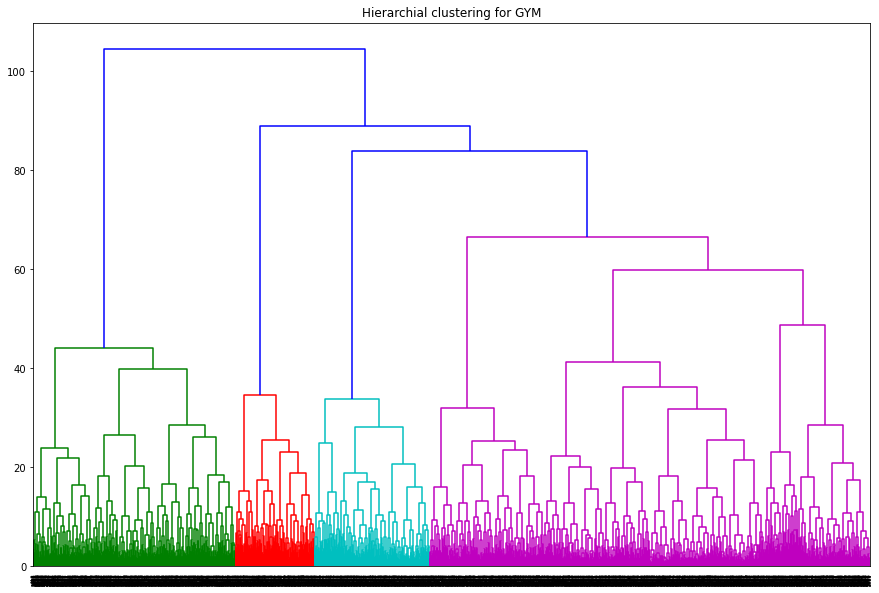

In [13]:
# нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

Дендрограмма предлагает разделение на 4 кластера. Однако в соответствии с условиями проекта будем делить на 5.

In [14]:
km = KMeans(n_clusters = 5, random_state=42) # задаём модель k_means с числом кластеров 5
labels = km.fit_predict(X_sc) # прогнозируем кластеры для наблюдений
gym['cluster'] = labels # сохраняем метки кластера в поле нашего датасета
gym['cluster'] +=1 # зададим нумерацию, начиная с 1, а не 0

# выведем статистику по средним значениям наших признаков по кластеру
gym_new = gym.groupby('cluster').agg('mean')
gym_new

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,,
1,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
2,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
3,0.484536,1.000000,0.350515,0.238699,1.000000,1.953212,0.340999,28.165741,131.686305,1.861221,2.432197,1.247327,1.012716,0.514671
4,0.560284,0.976359,0.360520,0.236407,0.998818,2.689125,0.470449,30.114657,161.376306,2.479905,4.892435,2.848556,2.846788,0.067376
5,0.503490,0.959123,0.782652,0.573280,1.000000,10.923230,0.546361,29.991027,160.881742,9.983051,4.748754,1.977676,1.970029,0.027916


Попробуем найти характеризующие признаки для каждого кластера: 
- кластер 1 - участники партнёрской программы, пришли через друзей, средняя активность
- кластер 2 - активные пользователи на среднесрочных контрактах (часто ходят, много тратят)
- кластер 3 - активные пользователи на долгосрочных контрактах (часто ходят, много тратят)
- кластер 4 - те, кто пришли не через друзей, мало платит и редко ходит
- кластер 5 - средняя активность, не пользовались партнерской программой или промокодом друга и не указали телефон

#### Вывод
Судя по усредненному значению 'Churn' для кластеров, мы можем предположить:
- клиенты кластеров 2 и 3 (активные группы) не уйдут в отток
- клиенты кластера 4 (пассивная группа) скорее уйдут в отток
- около четверти клиентов кластеров 1 и 5 (средние группы) уйдет в отток, остальные останутся

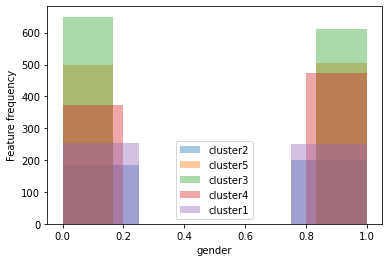

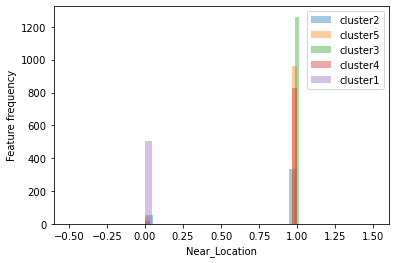

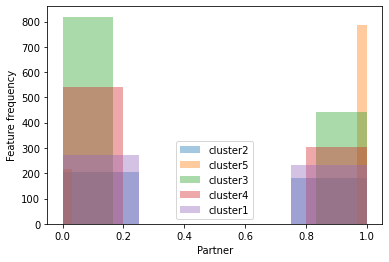

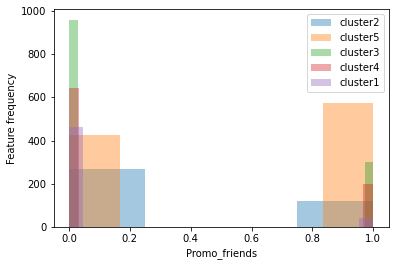

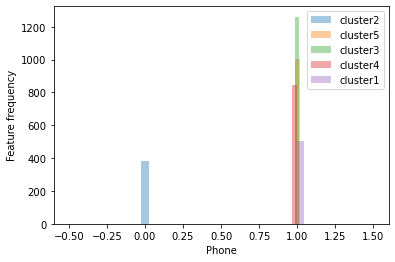

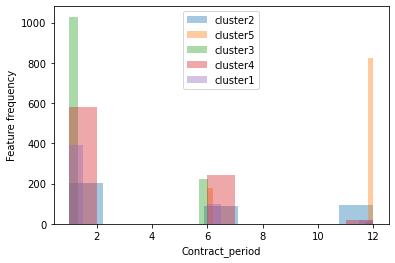

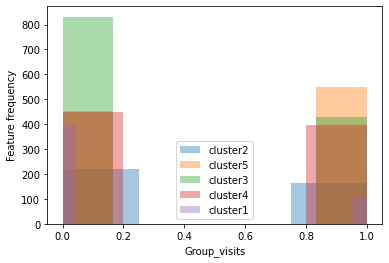

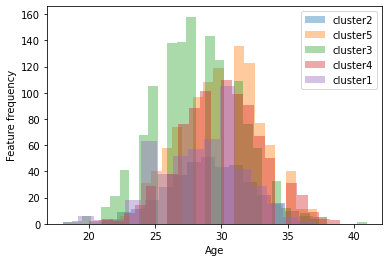

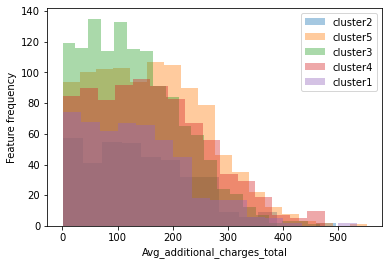

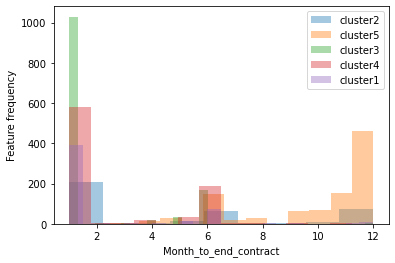

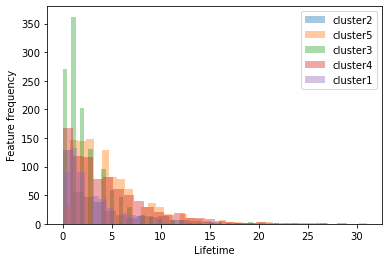

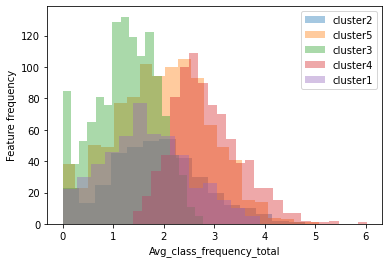

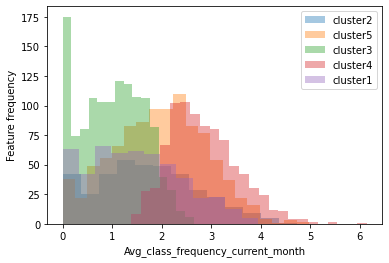

In [15]:
# посмотрим на распределение признаков по кластерам
for i in gym.columns[:-2]:
    for j in gym['cluster'].unique():
        sns.distplot(gym[gym['cluster']==j][i], kde=False, label='cluster'+str(j))
        plt.xlabel(i)
        plt.ylabel('Feature frequency')
        plt.legend()
    plt.show()

Графики распределения признаков по кластерам подтверждают наши предположения:
- клиенты кластера 4 моложе, реже ходят, меньше платят и имеют короткие контракты
- клиенты кластеров 2 и 3, наоборот, активно ходят и больше платят
- паттерны клиенты кластеров 1 и 5 - средние между активной и пассивной группами

In [16]:
# дополнительно для лучшей модели классификации попробуем определить, какой признак влиял на целевую переменную больше всего
final_model = LogisticRegression(random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
     
# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
importance = final_model.coef_[0]
weights = pd.DataFrame(data=abs(importance), index=gym.columns[:-2], columns=['Abs Weight']).sort_values(by='Abs Weight', ascending=False)
weights

,Abs Weight
Avg_class_frequency_current_month,5.079862
Avg_class_frequency_total,4.466464
Phone,1.078561
Lifetime,0.987750
Group_visits,0.569037
Promo_friends,0.409845
gender,0.357110
Month_to_end_contract,0.199260
Partner,0.193613
Age,0.108072


#### Вывод:

Сильнее всего на вероятность оттока пользователя в следующем месяце влияет частота его посещений в текущем месяце, а также на протяжении всего периода занятий. Если человек часто пользуется услугами фитнес-центра, вряд ли он собирается его покидать.

<a id="conclusion"></a>
#### Шаг 5. Рекомендации и выводы.
#### Кластеризация.

Как показала наша модель, клиентов можно разделить на следующие кластеры:

1) активные пользователи с долгосрочными договорами;

2) активные пользователи с краткосрочными договорами;

3) среднеактивные пользователи-"одиночки";

4) "компанейские" среднеактивные пользователи;

5) малоактивные пользователи-"одиночки".

Мы прогнозируем, что в следующем месяце уйдет около половины клиентов 5 кластера и около четверти клиентов 3 и 4 кластера. Практически все клиенты 1 и 2 кластеров останутся.

#### Факторы оттока.

При этом оказалось, что наиболее яркий индикатор скорого оттока клиента - <b>интенсивность занятий в последнее время</b>. Если клиентов стал ходить очень редко, вероятнее всего, он перестанет ходить в спортзал вовсе.

Кроме того, более склонны к оттоку клиенты, которые:

1) мало тратят на дополнительные услуги;

2) пришли не по партнёрской программе или приглашению друга;

3) заключают контракты на короткий срок.

#### Рекомендации.
На основании указанного мы делаем следующие маркетинговые рекомендации:

1) <b>укреплять социальные связи клиентов,</b> ведь чем сильнее клиент связан с другими посетителями, тем маловероятнее его отток.

К примеру, можно каждому новому клиенту предлагать несколько бесплатных посещений групповых занятий, где тот сможет ощутить себя частью коллектива, а также предоставлять бонусы за привлечение друзей.

2) <b>стимулировать дополнительные траты клиентов.</b>

Новым клиентам можно предоставлять скидку на первое использование дополнительных услуг (инструктор/сауна/...), что позволит им ощутить новую потребность и стать затем постоянным пользователем этих услуг. В свою очередь, чем больше клиент получает в спортзале, тем сильнее его связи с ним и тем меньше вероятность его оттока.

3) <b>реагировать на частоту посещений клиента.</b>

Если мы видим, что срок договора не закончился, а человек перестал к нам ходить, стоит ненавязчиво (посредством электронной почты или смс) напомнить человеку о возможности посетить спортзал. Это поможет клиенту поддерживать привычку посещать наш фитнес-центр.

4) <b>стимулировать продажу долгосрочных абонементов.</b>

Стоит обратить внимание на предоставление скидок при заключении долгосрочных договоров: чем дольше абонемент - тем меньше вероятность ухода клиента.